In [7]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

In [323]:
# reload helper and methods for when things change
reload(m);
reload(h);

### Generate Data

A:
[[ 0.    0.    0.  ]
 [ 0.67  0.    0.  ]
 [ 0.56  0.   -0.57]]

P:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]].


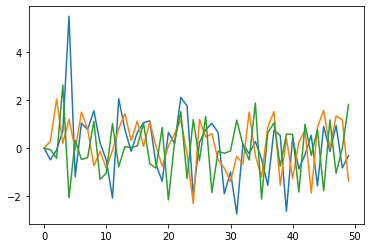

In [458]:
## Number of dimensions, number of edges, number of samples
T, n, s = 50, 3, 3

## Coefficient matrix
A_true = h.generate_A(n, s, low = 0.4, high = 0.7, tril = False)

## True permutation
P_true = np.identity(n)

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.")

### Perform OLS

In [447]:
def OLS(X):
    """Performs OLS on the data X"""
    
    # initialize OLS matrix
    W_OLS = np.zeros((n, n))
    
    # get per column
    for i in range(n):
        # closed form solution per OLS
        W_OLS[:, i] = np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:, i]
        
    # return OLS solution
    return W_OLS

print(f"Dense OLS solution:\n{np.round(OLS(X), 2)}.")

Dense OLS solution:
[[-0.33  0.28  0.08 -0.02 -0.1   0.13  0.3  -0.02  0.18  0.2 ]
 [ 0.25  0.15  0.18  0.02 -0.26  0.12  0.12  0.15 -0.02  0.21]
 [-0.13  0.3   0.2  -0.02 -0.14  0.07  0.09 -0.12  0.03  0.19]
 [ 0.8   0.15 -0.63  0.18 -0.02  0.08 -0.24 -0.09  0.09  0.2 ]
 [-0.11  0.1  -0.22  0.03 -0.11 -0.26 -0.18 -0.01  0.06  0.03]
 [-0.02  0.33 -0.23  0.32  0.2   0.21 -0.04  0.14  0.02  0.11]
 [ 0.06  0.1   0.17 -0.15 -0.2   0.08 -0.64 -0.1   0.16  0.14]
 [-0.13  0.17 -0.06  0.07  0.3  -0.21 -0.07 -0.19  0.09  0.01]
 [-0.09  0.13  0.02  0.02 -0.22 -0.63 -0.43  0.16  0.07 -0.07]
 [ 0.01 -0.04  0.15  0.17  0.27  0.01 -0.2  -0.34 -0.15 -0.11]].


### Backwards selection step
Given a matrix $W$, we find the violating edge $W_{i, j}$ that minimally decreases the Mean Squared Error. We continue until we have no violators. In this manner, we do not unnecessarily remove any edges.

In [448]:
def get_possible_violators(W):
    nonzero = np.nonzero(W - np.diag(np.diag(W)))
    
    return list(zip(nonzero[0], nonzero[1]))

In [449]:
print(get_possible_violators(OLS(X)))

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8)]


In [456]:
def get_all_violating_edges(W):
    """Returns all the edges of W that violate DAG-ness"""
    
    # initialize set of violators
    violators = set()
    
    # convert W to a graph to utilize networkx to find all simple cycles
    G = networkx.from_numpy_matrix(W, create_using=networkx.DiGraph)
    
    print(networkx.cycle_basis(G))
    possible_violators = get_possible_violators(W)
    
    # for each cycle
    for cycle in networkx.simple_cycles(G):
        # we get all cycles of length > 1 and write them in edge form
        edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle)) if len(cycle) > 1]
        
        # we add them all to the set, so that we do not have duplicates
        for edge in edges:
            violators.add(edge)
        
        # speed up, check if all violators are found
        if violators.issuperset(possible_violators): 
            print("Break Early")
            return violators
            
    # we return all the violators
    return violators

print(f"All edges violating dag-ness in W_OLS: {get_all_violating_edges(OLS(X))}.")

NetworkXNotImplemented: not implemented for directed type

In [439]:
def backwards_selection_step(W, X):
    """Performs one backwards step in selection.
       We remove the least important edge that violates DAG-ness.
       Least important means that removing it yields the smallest MSE increase.
    """
    
    # get all violating edges
    violators = get_all_violating_edges(W)
    
    # if there are no violators, we are already done
    if len(violators) == 0: return W
    
    # variables to keep track of best
    best_col_to_change = None
    new_column = None
    score = np.inf

    # iterate over all violators
    for row, col in violators:
        # copy W_hat before modifying 
        W_copy = W.copy()
        
        # set index of violator to zero
        W_copy[row][col] = 0
    
        # get all non_zero indices after removing violator
        indices = W_copy[:, col].nonzero()[0]
        
        # perform least squares without this violator
        W_copy[indices, col] = np.linalg.inv(X[:-1, indices].T @ X[:-1, indices]) @ X[:-1, indices].T @ X[1:, col]
    
        # if we have improved, check if best choice so far
        if h.MSE(W_copy, X) < score:
            best_col_to_change = col
            new_column = W_copy[:, col]
            score = h.MSE(W_copy, X)
    
    # we greedily pick the best choice we have
    W[:, best_col_to_change] = new_column
    
    # return W_hat with one coefficient less
    return W

print(f"OLS solution after removing the least important violator:\n{np.round(backwards_selection_step(OLS(X), X), 2)}.")

Break Early
OLS solution after removing the least important violator:
[[ 0.71  0.01 -0.02  0.04  0.02  0.09  0.04 -0.06  0.  ]
 [-0.18 -0.21 -0.09  0.25  0.17 -0.06 -0.14  0.15 -0.01]
 [-0.26  0.11  0.04 -0.07 -0.06  0.07  0.19  0.    0.26]
 [-0.79 -0.01 -0.06  0.18 -0.05  0.1   0.07  0.04 -0.17]
 [-0.27 -0.03  0.02 -0.15 -0.12  0.04 -0.11  0.16 -0.04]
 [-0.21 -0.13 -0.06  0.63  0.31 -0.01  0.13 -0.06 -0.09]
 [ 0.06  0.02 -0.05  0.26 -0.06  0.55  0.18  0.03  0.24]
 [-0.09 -0.19 -0.39  0.25 -0.25 -0.14 -0.02 -0.07 -0.02]
 [-0.11  0.17 -0.02 -0.01  0.52  0.11  0.01 -0.01  0.11]].


In [451]:
def greedy_backwards_OLS(X):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = OLS(X)
    
    # while we still do not have a DAG
    while not h.is_dag(W):
        # greedily remove the edge that yields the smallest added error
        W = backwards_selection_step(W, X)
    
    # return the DAG W
    return W

W_greedy_backwards_OLS = greedy_backwards_OLS(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_greedy_backwards_OLS, 2)}.")

Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
Break Early
OLS solution after iteratively removing the least important violators until we have a DAG:
[[-0.28  0.13  0.    0.    0.    0.    0.23  0.    0.    0.  ]
 [ 0.    0.17  0.    0.   -0.27  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.06  0.    

In [452]:
if n <= 10: print(np.round(W_greedy_backwards_OLS, 2))
print(h.MSE(W_greedy_backwards_OLS, X))

[[-0.28  0.13  0.    0.    0.    0.    0.23  0.    0.    0.  ]
 [ 0.    0.17  0.    0.   -0.27  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.06  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.88  0.   -0.62  0.23  0.    0.   -0.28  0.    0.    0.  ]
 [ 0.    0.   -0.29  0.   -0.06  0.    0.    0.    0.    0.  ]
 [ 0.    0.33  0.    0.32  0.    0.18  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.67  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.3  -0.16  0.   -0.2   0.    0.  ]
 [ 0.    0.    0.    0.   -0.19 -0.54 -0.41  0.   -0.01  0.  ]
 [ 0.    0.    0.    0.    0.36  0.    0.    0.    0.   -0.07]]
8.199501911447813


In [357]:
if n <= 8: print(h.MSE(m._Exh(X), X))

  3%|██▋                                                                         | 1394/40320 [00:05<02:34, 251.94it/s]


KeyboardInterrupt: 

In [453]:
if n <= 10: print(np.round(m._OMP(X), 2))
print(h.MSE(m._OMP(X), X))

[[-0.32  0.    0.07  0.   -0.06  0.    0.23  0.    0.    0.  ]
 [ 0.24  0.12  0.16  0.   -0.27  0.    0.09  0.    0.    0.  ]
 [ 0.    0.    0.21  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.8   0.1  -0.64  0.21  0.    0.   -0.3  -0.04  0.    0.19]
 [ 0.    0.   -0.22  0.   -0.1   0.    0.    0.    0.    0.  ]
 [-0.05  0.34 -0.23  0.31  0.19  0.19 -0.08  0.12  0.    0.12]
 [ 0.    0.    0.17  0.   -0.18  0.   -0.67  0.    0.    0.  ]
 [-0.13  0.14 -0.06  0.    0.29  0.   -0.02 -0.19  0.    0.  ]
 [-0.06  0.06  0.02  0.06 -0.21 -0.54 -0.39  0.19 -0.01 -0.08]
 [ 0.09 -0.11  0.16  0.    0.32  0.   -0.17 -0.25  0.   -0.11]]
7.718944280866465
